## Arctic Chlor Data Review

- mooring data pulled from ERDDAP (preliminary and/or final)   
- currently on downdraft
- chlor data from 2017/2018

In [116]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter

import cmocean

In [117]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [118]:
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

**Lets find all erddap datasets that would be associated with Arctic:**  
+ 17ck, 18ck

In [119]:
e = ERDDAP(server=server_url)
df_1 = pd.read_csv(e.get_search_url(response='csv', search_for='17ck'))
e = ERDDAP(server=server_url)
df_2 = pd.read_csv(e.get_search_url(response='csv', search_for='18ck'))

df = pd.concat([df_1,df_2])
print(df['Dataset ID'].values)

['datasets_Mooring_17ckp10a_final' 'datasets_Mooring_17ckp10a_preliminary'
 'datasets_Mooring_17ckp11a_final' 'datasets_Mooring_17ckp11a_preliminary'
 'datasets_Mooring_17ckp12a_final' 'datasets_Mooring_17ckp12a_preliminary'
 'datasets_Mooring_17ckp1a_final' 'datasets_Mooring_17ckp1a_preliminary'
 'datasets_Mooring_17ckp2a_final' 'datasets_Mooring_17ckp2a_preliminary'
 'datasets_Mooring_17ckp3a_final' 'datasets_Mooring_17ckp3a_preliminary'
 'datasets_Mooring_17ckp4a_final' 'datasets_Mooring_17ckp4a_preliminary'
 'datasets_Mooring_17ckp5a_final' 'datasets_Mooring_17ckp5a_preliminary'
 'erddap_17ckitaem2a_prawler' 'erddap_17ckitaem2a_met'
 'datasets_Mooring_18ck14a_final' 'datasets_Mooring_18ck14a_preliminary'
 'datasets_Mooring_18ckp10a_final' 'datasets_Mooring_18ckp10a_preliminary'
 'datasets_Mooring_18ckp12a_preliminary' 'datasets_Mooring_18ckp1a_final'
 'datasets_Mooring_18ckp1a_preliminary' 'datasets_Mooring_18ckp2a_final'
 'datasets_Mooring_18ckp2a_preliminary' 'datasets_Mooring_18

In [120]:
variables = [d.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in df['Dataset ID'].values]
flatten = lambda l: [item for sublist in l for item in sublist]
flat = flatten(variables)
print(set(flat))

{'Chlorophyll_Fluorescence', 'Oxy_Sat', 'Temperature', 'wind_speed', 'Oxy_Conc', 'temperature', 'Chlorophyll', 'Oxy_Temperature', 'longitude', 'latitude', 'eastward_wind', 'northward_wind', 'Salinity', 'air_temperature', 'Oxygen_Saturation', 'wind_from_direction', 'depth', 'relative_humidity', 'Turbidity', 'time', 'salinity', 'Oxygen_Concentration', 'air_pressure', 'SigmaT'}


In [121]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in df['Dataset ID'].values:
    print(dataset_id)
    if 'prawler' in dataset_id:
        continue
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id

        d.variables = ['time','depth','Chlorophyll_Fluorescence']
        
        print(d.get_download_url())
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        df_m.dropna(inplace=True) #placing it here drops na values prior to qc of relevant datastreams

        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        df_m['Chlorophyll_Fluorescence'][(df_m.depth == -9999)] = np.nan # only in pressure field
        df_m[df_m['Chlorophyll_Fluorescence'] > 1e34] = np.nan # only in primary param fields 

        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_17ckp10a_final
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp10a_final.csv?time,depth,Chlorophyll_Fluorescence
datasets_Mooring_17ckp10a_preliminary
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp10a_preliminary.csv?time,depth,Chlorophyll_Fluorescence
datasets_Mooring_17ckp11a_final
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp11a_final.csv?time,depth,Chlorophyll_Fluorescence
datasets_Mooring_17ckp11a_preliminary
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp11a_preliminary.csv?time,depth,Chlorophyll_Fluorescence
datasets_Mooring_17ckp12a_final
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp12a_final.csv?time,depth,Chlorophyll_Fluorescence
datasets_Mooring_17ckp12a_preliminary
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp12a_preliminary.csv?time,depth,Chlorophyll_Fluorescence
datasets_Mooring_17ckp1a_fin

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


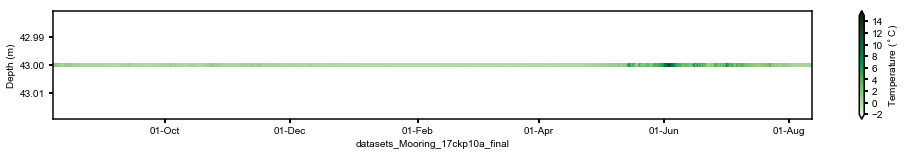

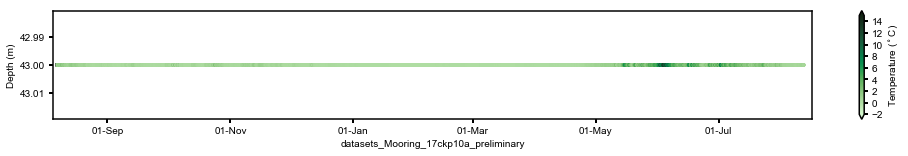

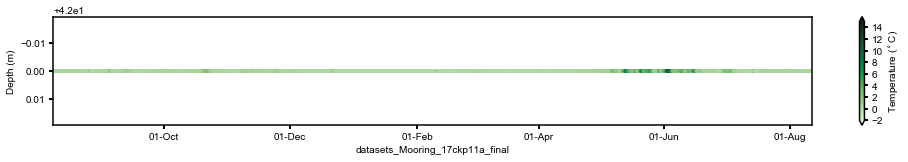

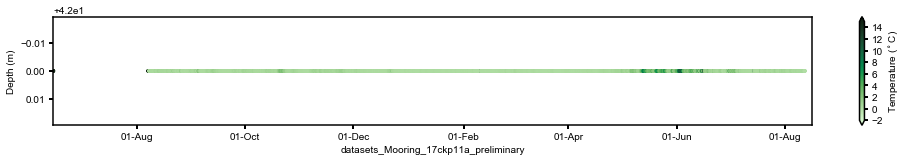

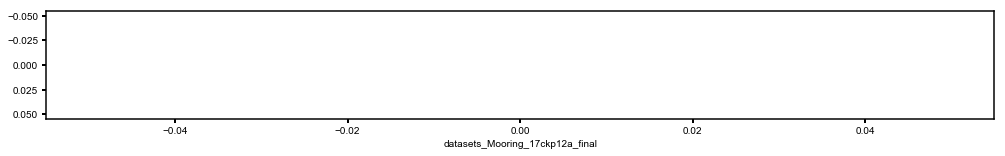

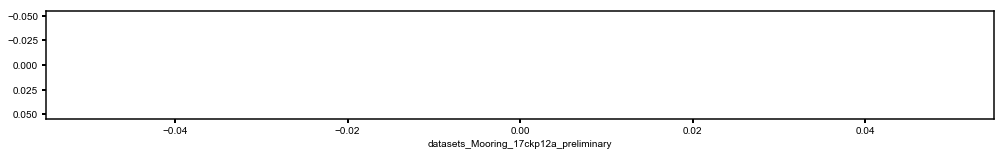

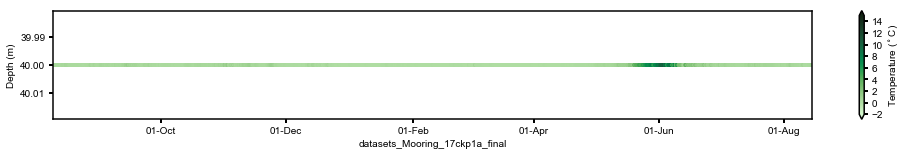

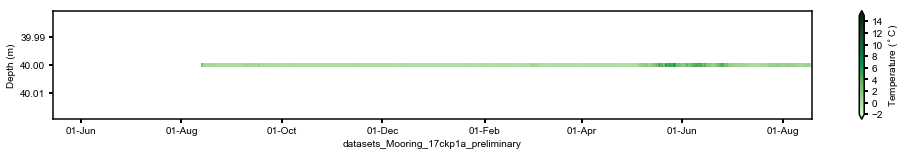

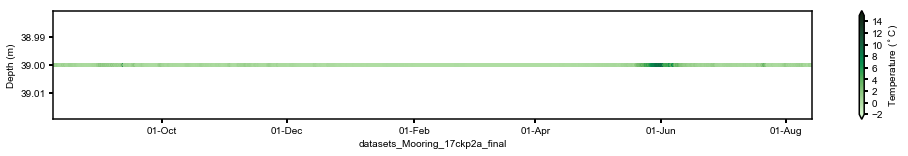

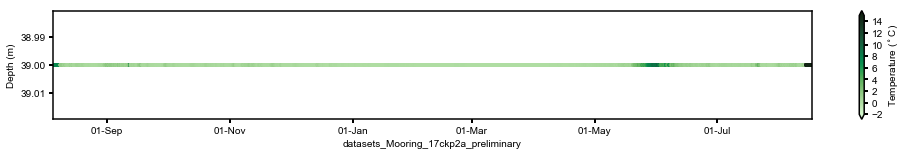

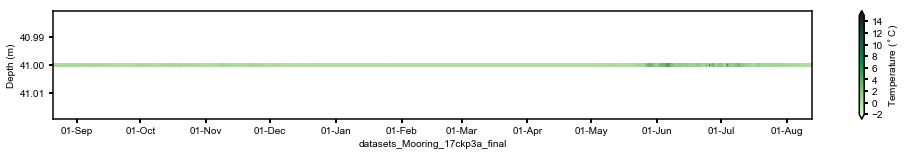

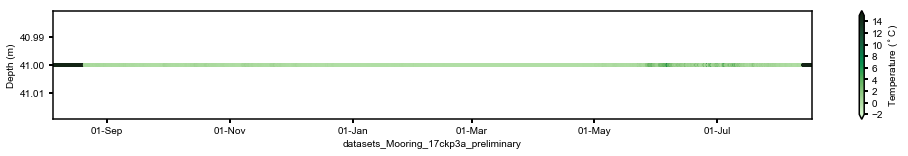

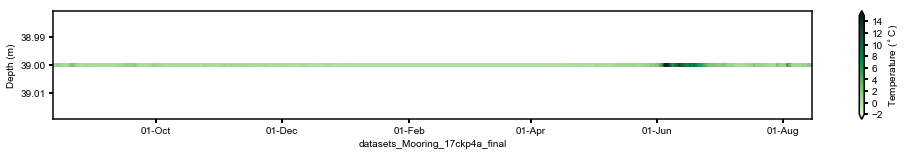

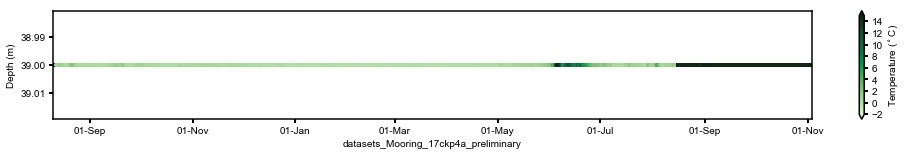

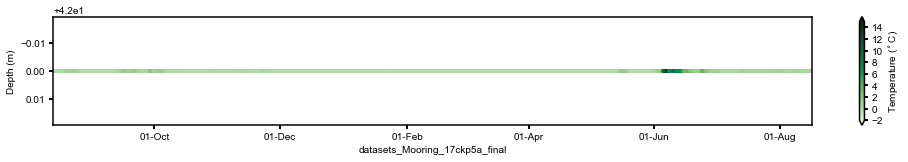

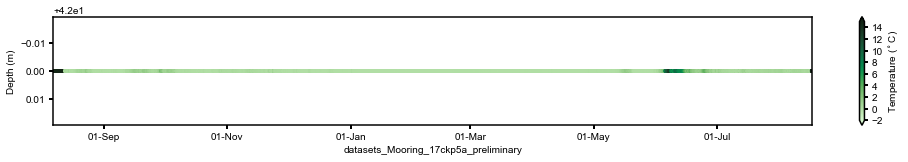

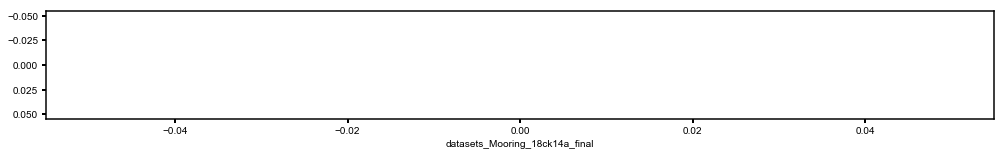

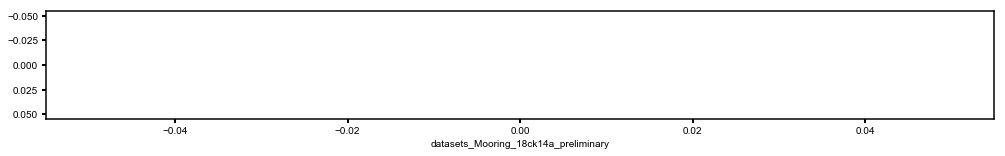

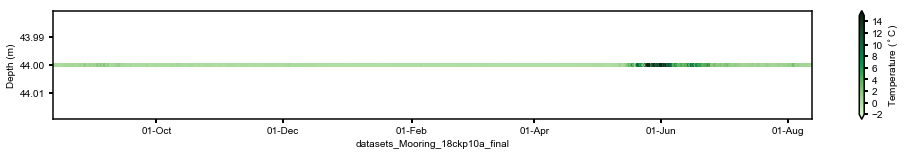

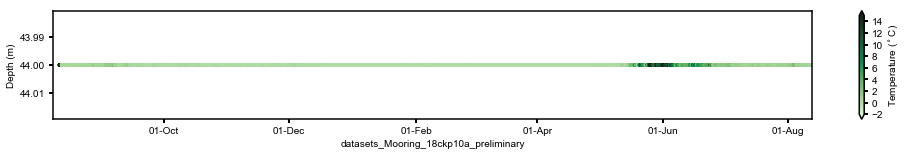

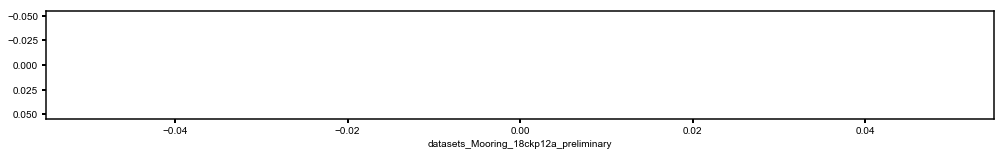

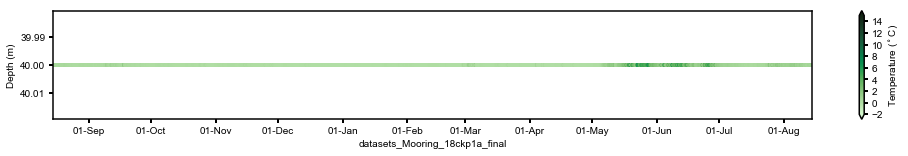

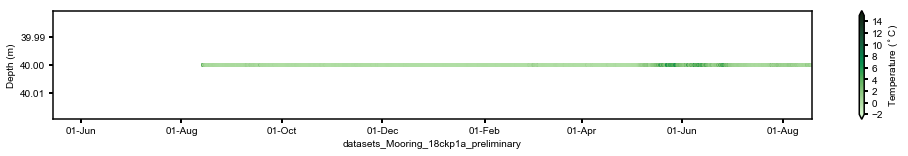

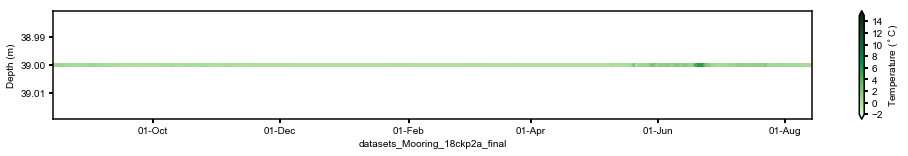

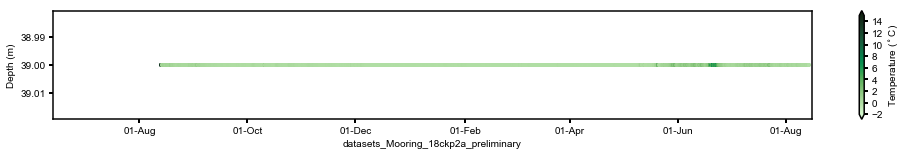

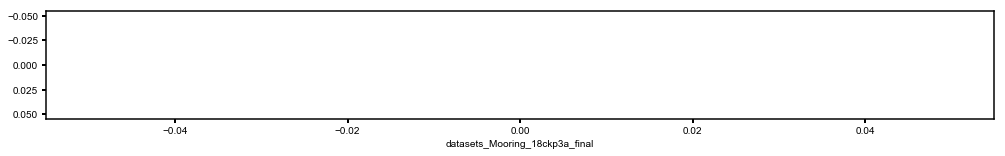

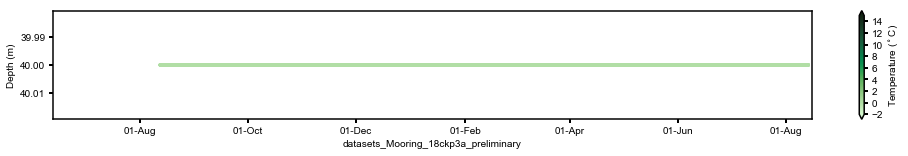

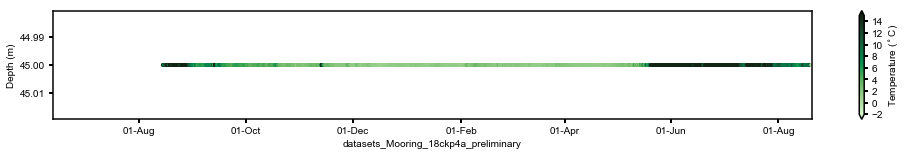

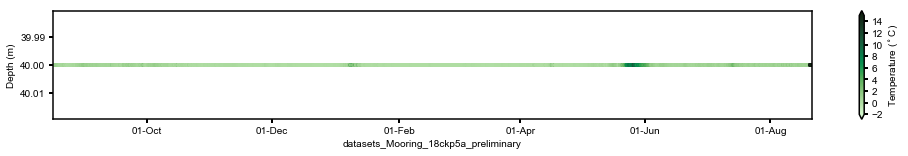

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    try:
        if 'final' in dfn:
            fig, ax = plt.subplots(figsize=(17, 2))
            cs = ax.scatter(df.index, df['depth'], s=15, c=df['Chlorophyll_Fluorescence'], marker='o', edgecolor='none', vmin=-2, vmax=15, cmap=cmocean.cm.algae)

            ax.invert_yaxis()
            ax.set_xlim(df.index[0], df.index[-1])
            xfmt = mdates.DateFormatter('%d-%b')
            ax.xaxis.set_major_formatter(xfmt)

            cbar = fig.colorbar(cs, orientation='vertical', extend='both')
            cbar.ax.set_ylabel('Temperature ($^\circ$C)')
            ax.set_ylabel('Depth (m)')
            ax.set_xlabel(dfn)

            #fig.savefig(dfn+'.png',dpi=300)
        elif 'preliminary' in dfn:
            fig, ax = plt.subplots(figsize=(17, 2))
            cs = ax.scatter(df.index, df['depth'], s=15, c=df['Chlorophyll_Fluorescence'], marker='o', edgecolor='none', vmin=-2, vmax=15, cmap=cmocean.cm.algae)

            ax.invert_yaxis()
            ax.set_xlim(df.index[0], df.index[-1])
            xfmt = mdates.DateFormatter('%d-%b')
            ax.xaxis.set_major_formatter(xfmt)

            cbar = fig.colorbar(cs, orientation='vertical', extend='both')
            cbar.ax.set_ylabel('Temperature ($^\circ$C)')
            ax.set_ylabel('Depth (m)')
            ax.set_xlabel(dfn)
    except:
        ax.set_xlabel(dfn)
        continue

Text(0,0.5,'Chlor. Fluor\n (ugrams/l)')

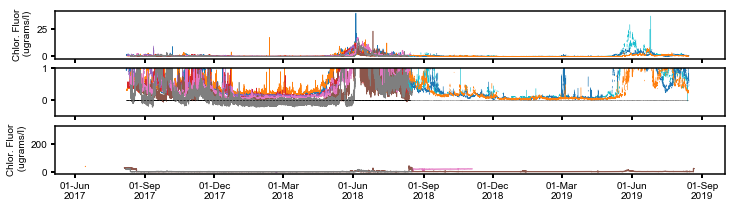

In [123]:
### final only
fig, (ax3, ax2, ax1) = plt.subplots(3,1,sharex='col',figsize=(12,3))
for dfn, df in dfs.items():
    if 'final' in dfn:
        ax3.plot(df.index.values, df['Chlorophyll_Fluorescence'],linewidth=0.625, label=dfn)

        ax2.plot(df.index.values, df['Chlorophyll_Fluorescence'],linewidth=0.625, label=dfn)
        ax2.plot(df.index.values, df['Chlorophyll_Fluorescence']*0,'k--',linewidth=0.625, label=dfn)
        ax2.set_ylim([-0.5,1])
        
ax3.xaxis.set_major_formatter(xfmt)
ax3.set_ylabel('Chlor. Fluor\n (ugrams/l)')


for dfn, df in dfs.items():
    if 'preliminary' in dfn:
        ax1.plot(df.index.values, df['Chlorophyll_Fluorescence'],linewidth=1.25, label=dfn)

xfmt = mdates.DateFormatter('%d-%b\n%Y')
ax1.xaxis.set_major_formatter(xfmt)

ax1.set_ylabel('Chlor. Fluor\n (ugrams/l)')

Text(0,0.5,'Chlor. Fluor\n (ugrams/l)')

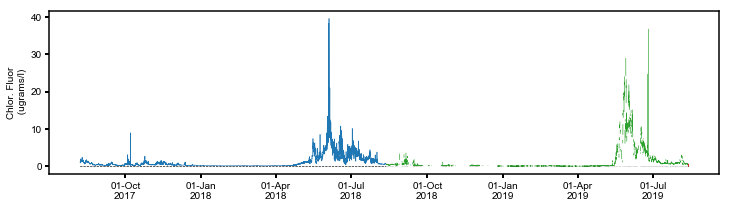

In [124]:
### final only
fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(12,3))
for dfn, df in dfs.items():
    if 'ckp10' in dfn:
        ax1.plot(df.index.values, df['Chlorophyll_Fluorescence'],linewidth=0.625, label=dfn)

        ax1.plot(df.index.values, df['Chlorophyll_Fluorescence']*0,'k--',linewidth=0.625, label=dfn)
        

xfmt = mdates.DateFormatter('%d-%b\n%Y')
ax1.xaxis.set_major_formatter(xfmt)

ax1.set_ylabel('Chlor. Fluor\n (ugrams/l)')

